# Time-series forecasting with latent compression of multivariate input

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [18]:
# ============================================================
# 1. Feature engineering
# ============================================================

def create_features_from_series(series: pd.Series,
                                lags=(1, 2, 7, 14, 30),
                                rolling_windows=(3, 7)) -> pd.DataFrame:
    """
    Create a multivariate feature matrix from a univariate daily series.
    - Time-based features (day of week, month, etc.)
    - Lag features
    - Rolling means
    """
    df = pd.DataFrame({'y': series})

    # Time-based features (use datetime index)
    df['dayofweek'] = df.index.dayofweek  # 0=Monday
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Lag features
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Rolling means on the original series
    for win in rolling_windows:
        df[f'roll_mean_{win}'] = df['y'].rolling(window=win).mean()

    # Drop initial rows with NaNs due to lags/rolling
    df = df.dropna()

    return df


# ============================================================
# 2. Autoencoder model (latent compression)
# ============================================================

def build_autoencoder(input_dim: int, latent_dim: int) -> (Model, Model, Model):
    """
    Build a simple fully-connected autoencoder in Keras.
    Returns: (autoencoder, encoder, decoder)
    """
    # Encoder
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(input_layer)
    latent = Dense(latent_dim, name='latent')(x)

    # Decoder
    x_dec = Dense(64, activation='relu')(latent)
    output_layer = Dense(input_dim, activation='linear')(x_dec)

    autoencoder = Model(inputs=input_layer, outputs=output_layer, name="autoencoder")
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    # Separate encoder model
    encoder = Model(inputs=input_layer, outputs=latent, name="encoder")

    # Separate decoder model
    latent_input = Input(shape=(latent_dim,))
    x_dec2 = autoencoder.layers[-2](latent_input)   # Dense(64, relu)
    output_dec2 = autoencoder.layers[-1](x_dec2)    # Dense(input_dim)
    decoder = Model(inputs=latent_input, outputs=output_dec2, name="decoder")

    return autoencoder, encoder, decoder


# ============================================================
# 3. Latent-space forecaster (scikit-learn)
# ============================================================

def build_latent_forecaster():
    """
    Build a MultiOutputRegressor over RandomForest for latent space forecasting.
    z_t -> z_{t+1}
    """
    base = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    forecaster = MultiOutputRegressor(base)
    return forecaster


def iterative_forecast_latent(forecaster, z_start: np.ndarray, n_steps: int) -> np.ndarray:
    """
    Iterative forecasting in latent space.
    - z_start: shape (latent_dim,)
    - n_steps: forecast horizon
    Returns array shape (n_steps, latent_dim)
    """
    z_current = z_start.reshape(1, -1)
    preds = []

    for _ in range(n_steps):
        z_next = forecaster.predict(z_current)  # shape (1, latent_dim)
        preds.append(z_next.ravel())
        z_current = z_next

    return np.vstack(preds)


# ============================================================
# 4. Main experiment
# ============================================================

def run_experiment(series: pd.Series,
                   latent_dim: int = 3,
                   forecast_horizon: int = 30,
                   train_ratio: float = 0.8):
    """
    Full experiment:
    1) Feature engineering
    2) Train autoencoder (compression)
    3) Encode to latent space
    4) Train forecaster z_t -> z_{t+1}
    5) Iterative forecast in latent space
    6) Decode and evaluate on MAE, MSE, RMSE
    """

    # 1. Feature engineering
    features_df = create_features_from_series(series)
    print("Feature columns:", list(features_df.columns))

    # Target is the original series (current day y)
    y_all = features_df['y'].values
    X_all = features_df.values  # all features (y + time-based + lags + rolling)

    # 2. Train / test split (time-based)
    n_samples = len(features_df)
    n_train = int(train_ratio * n_samples)
    X_train, X_test = X_all[:n_train], X_all[n_train:]
    y_train, y_test = y_all[:n_train], y_all[n_train:]

    print(f"Total samples after feature engineering: {n_samples}")
    print(f"Train samples: {n_train}, Test samples: {n_samples - n_train}")

    # 3. Build and train autoencoder on TRAIN ONLY (to avoid leakage)
    input_dim = X_all.shape[1]
    autoencoder, encoder, decoder = build_autoencoder(input_dim=input_dim,
                                                      latent_dim=latent_dim)

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        X_train,
        X_train,
        epochs=100,
        batch_size=32,
        shuffle=False,
        validation_split=0.1,
        callbacks=[es],
        verbose=1
    )

    # 4. Encode full dataset into latent space
    Z_all = encoder.predict(X_all)
    Z_train, Z_test = Z_all[:n_train], Z_all[n_train:]

    # 5. Prepare training data for latent forecaster (z_t -> z_{t+1})
    # Use only train part, no leakage across train/test boundary.
    Z_train_in = Z_train[:-1]
    Z_train_out = Z_train[1:]

    forecaster = build_latent_forecaster()
    forecaster.fit(Z_train_in, Z_train_out)

    # 6. Iterative forecast from last train latent point
    z_start = Z_train[-1]  # latent representation at last train time step

    # Number of steps we can actually evaluate = min(horizon, len(Z_test))
    effective_horizon = min(forecast_horizon, len(Z_test))
    Z_future_hat = iterative_forecast_latent(
        forecaster=forecaster,
        z_start=z_start,
        n_steps=effective_horizon
    )

    # 7. Decode latent predictions to original feature space
    X_future_hat = decoder.predict(Z_future_hat)  # shape (effective_horizon, input_dim)

    # First column in features_df is 'y', so we take column 0 as predicted series
    y_future_hat = X_future_hat[:, 0]

    # 8. Prepare true values for evaluation
    y_true = y_test[:effective_horizon]

    # 9. Metrics
    mae = mean_absolute_error(y_true, y_future_hat)
    mse = mean_squared_error(y_true, y_future_hat)
    rmse = np.sqrt(mse)

    print("=== Evaluation (forecasting in original space) ===")
    print(f"Horizon used: {effective_horizon} days")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Vrnemo, če želiš nadaljnjo analizo
    results = {
        'y_true': y_true,
        'y_pred': y_future_hat,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'latent_dim': latent_dim,
        'forecast_horizon': forecast_horizon,
        'effective_horizon': effective_horizon
    }
    return results


# ============================================================
# 5. Primer uporabe
# ============================================================

#if __name__ == "__main__":
    # Primer: branje iz CSV (prilagodi svojim podatkom)
    # CSV naj ima stolpec 'date' in 'consumption'
    # df = pd.read_csv("daily_consumption.csv", parse_dates=['date'])
    # df = df.set_index('date')
    # series = df['consumption'].asfreq('D')

    # Tukaj samo primer, kako pokličeš:
    # results = run_experiment(series,
    #                          latent_dim=5,
    #                          forecast_horizon=30,
    #                          train_ratio=0.8)
#    pass


In [19]:
def plot_series(series, train_ratio=0.8):
    n = len(series)
    n_train = int(train_ratio * n)

    # Razbij serijo na train + test
    train_series = series.iloc[:n_train]
    test_series = series.iloc[n_train:]

    plt.figure(figsize=(14,6))

    # Train: modra, tanka
    plt.plot(train_series.index, train_series.values,
             color='blue', linewidth=1, label='Train (true)')

    # Test: zelena, tanka
    plt.plot(test_series.index, test_series.values,
             color='green', linewidth=1, label='Test (true)')

    plt.title("Time series")
    plt.xlabel("Datum")
    plt.ylabel("Poraba")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    

def plot_forecast(series, results, train_ratio=0.8):
    """
    Nariše:
    - modro: dejanske vrednosti v učnem delu
    - zeleno: dejanske vrednosti v testnem delu
    - rdeče: napovedi
    """
    y_true = results['y_true']
    y_pred = results['y_pred']
    effective_horizon = results['effective_horizon']

    n = len(series)
    n_train = int(train_ratio * n)

    # Razbij serijo na train + test
    train_series = series.iloc[:n_train]
    test_series = series.iloc[n_train : n_train + effective_horizon]

    plt.figure(figsize=(14,6))

    # Train: modra, tanka
    plt.plot(train_series.index, train_series.values,
             color='blue', linewidth=1, label='Train (true)')

    # Test: zelena, tanka
    plt.plot(test_series.index, test_series.values,
             color='green', linewidth=1, label='Test (true)')

    # Napovedi: rdeča, debelejša
    plt.plot(test_series.index, y_pred,
             color='red', linewidth=2.5, label='Napoved')

    #plt.title(f"Forecast results (latent_dim={results['latent_dim']}, horizon={results['forecast_horizon']})")
    plt.title("Forecast results")
    plt.xlabel("Datum")
    plt.ylabel("Poraba")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_forecast_comparison(series,
                             latent_results,
                             baseline_results,
                             train_ratio: float = 0.8):
    """
    Nariše skupen graf:
      - modro: dejanske vrednosti (train)
      - zeleno: dejanske vrednosti (test)
      - rdeče: latentna napoved
      - oranžno, črtkano: baseline napoved
    """

    # Skupni eval horizont = min obeh
    h_latent = latent_results['effective_horizon']
    h_base = baseline_results['effective_horizon']
    horizon = min(h_latent, h_base)

    # Resnične vrednosti (vzamemo iz latent ali baseline, morajo biti iste v prvih 'horizon' korakih)
    y_true = latent_results['y_true'][:horizon]
    y_pred_latent = latent_results['y_pred'][:horizon]
    y_pred_base = baseline_results['y_pred'][:horizon]

    # Train/test razbitje indeksa
    n = len(series)
    n_train = int(train_ratio * n)

    train_series = series.iloc[:n_train]
    # test del, ki ga dejansko uporabljamo za primerjavo
    test_series = series.iloc[n_train:n_train + horizon]

    plt.figure(figsize=(14, 6))

    # 1) Train del: modra tanka črta
    plt.plot(train_series.index,
             train_series.values,
             color='blue',
             linewidth=1,
             label='Train (true)')

    # 2) Test del: zelena tanka črta
    plt.plot(test_series.index,
             test_series.values,
             color='green',
             linewidth=1,
             label='Test (true)')

    # 3) Latentna napoved: rdeča debelejša črta
    plt.plot(test_series.index,
             y_pred_latent,
             color='red',
             linewidth=2.5,
             label='Napoved (latentni prostor)')

    # 4) Baseline napoved: oranžna debelejša črtkana črta
    plt.plot(test_series.index,
             y_pred_base,
             color='orange',
             linewidth=2.5,
             label='Napoved (baseline)')

    plt.title(
        "Primerjava napovedi: latentni model vs baseline\n"
        f"latent_dim={latent_results.get('latent_dim', 'N/A')}, "
        f"horizon_latent={latent_results['forecast_horizon']}, "
        f"horizon_baseline={baseline_results['forecast_horizon']}, "
        f"prikazan horizon={horizon}"
    )
    plt.xlabel("Datum")
    plt.ylabel("Poraba")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    

In [20]:
df = pd.read_csv("mm12007.csv", parse_dates=['datum'])
df = df.set_index('datum')
series = df['vrednost'].asfreq('D')

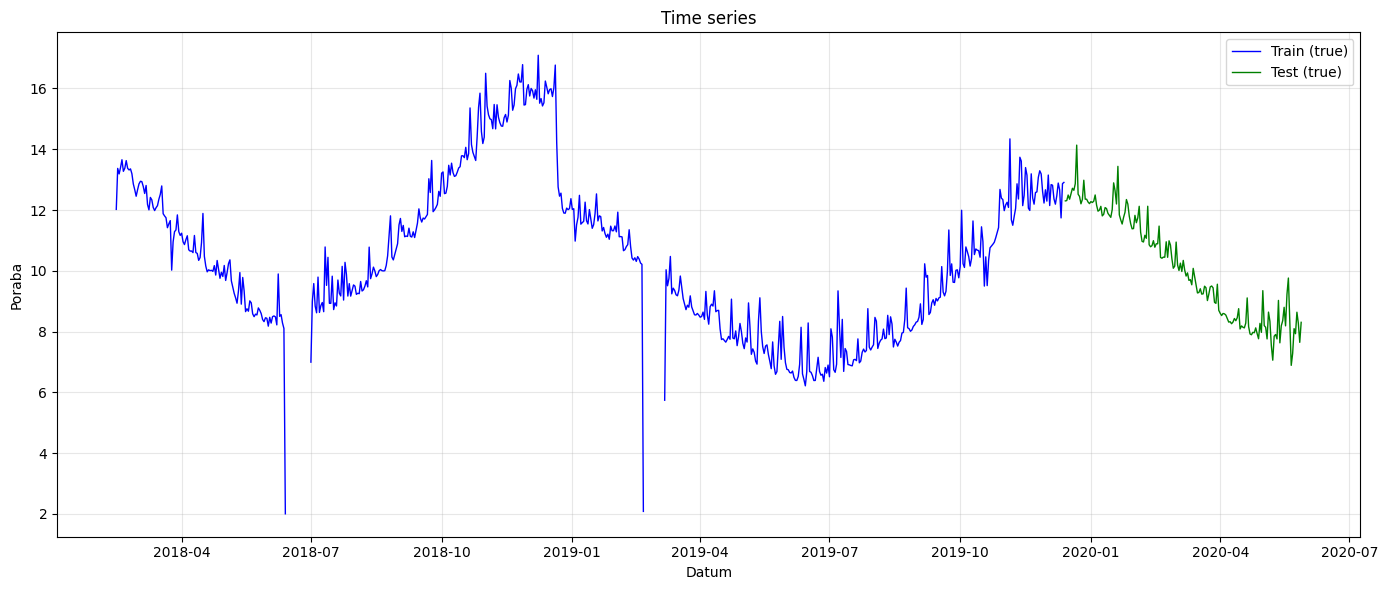

In [21]:
plot_series(series, train_ratio=0.8)

In [22]:
results = run_experiment(series, latent_dim=5, forecast_horizon=100, train_ratio=0.8)

Feature columns: ['y', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_3', 'roll_mean_7']
Total samples after feature engineering: 716
Train samples: 572, Test samples: 144
Epoch 1/100
17/17 [==============================] - 0s 4ms/step - loss: 3308.5674 - val_loss: 5932.5659
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 2035.7777 - val_loss: 2855.2646
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 686.7424 - val_loss: 479.4049
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 65.7604 - val_loss: 40.4199
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 32.2237 - val_loss: 19.8086
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 20.8795 - val_loss: 19.6216
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 18.0922 - val_loss: 14.7105
Epoch 8/100
17/17 [==============================] 

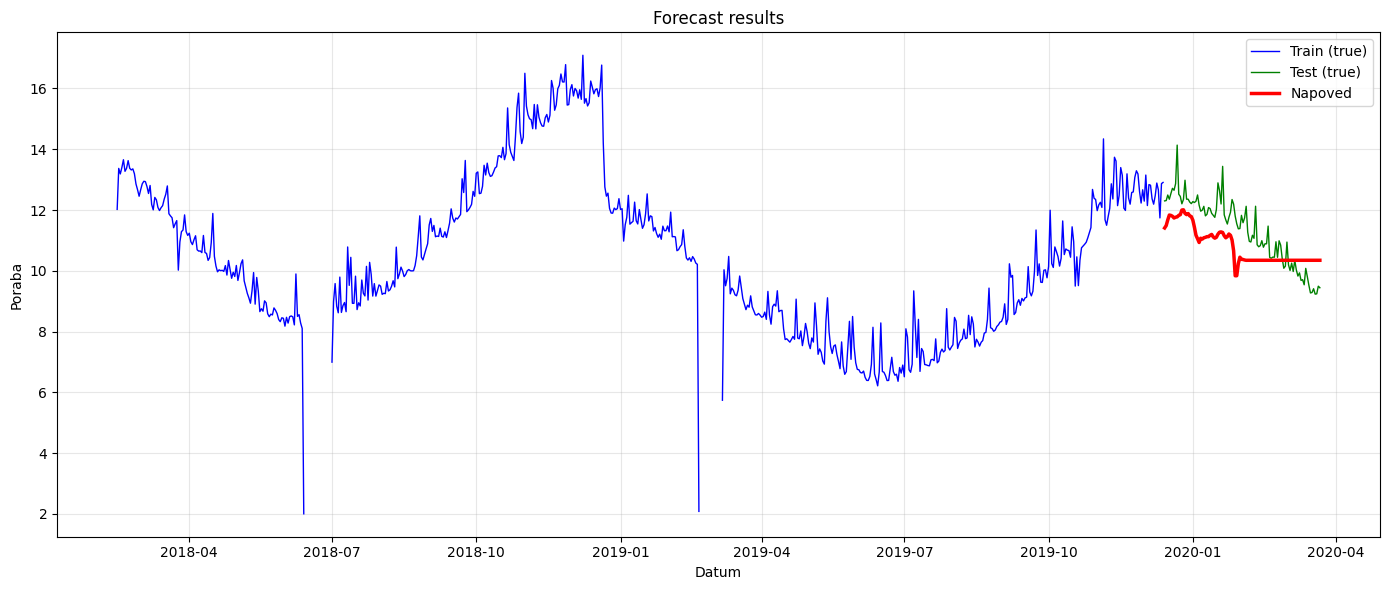

In [23]:
plot_forecast(series, results, train_ratio=0.8)

### Primerjava z baseline pristopom, kjer ne uporabimo latentne kompresije

In [24]:
def build_baseline_forecaster():
    """
    Multi-output RandomForest za napoved v izvirnem prostoru značilnic:
    X_t -> X_{t+1}
    """
    base = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    forecaster = MultiOutputRegressor(base)
    return forecaster


def iterative_forecast_features(forecaster, x_start: np.ndarray, n_steps: int) -> np.ndarray:
    """
    Iterativno napovedovanje v prostoru značilnic.
    - x_start: shape (n_features,)
    - n_steps: dolžina horizonta
    Vrne: array shape (n_steps, n_features)
    """
    x_current = x_start.reshape(1, -1)
    preds = []

    for _ in range(n_steps):
        x_next = forecaster.predict(x_current)  # shape (1, n_features)
        preds.append(x_next.ravel())
        x_current = x_next

    return np.vstack(preds)

def run_baseline_experiment(series: pd.Series,
                            forecast_horizon: int = 30,
                            train_ratio: float = 0.8):
    """
    Baseline eksperiment:
    1) Feature engineering (isti kot prej)
    2) Train/test time-split
    3) Nauči forecaster X_t -> X_{t+1} v izvirnem prostoru
    4) Iterativno napoveduje X v prihodnost
    5) Za metrike uporabi prvi stolpec (y)
    """

    # 1. Feature engineering – ista funkcija kot pri latentnem modelu
    features_df = create_features_from_series(series)
    print("Feature columns:", list(features_df.columns))

    # Target za evalvacijo je originalni 'y', a model napoveduje cel X
    y_all = features_df['y'].values
    X_all = features_df.values  # (y + časovne + lags + rolling)

    # 2. Train/test split
    n_samples = len(features_df)
    n_train = int(train_ratio * n_samples)
    X_train, X_test = X_all[:n_train], X_all[n_train:]
    y_train, y_test = y_all[:n_train], y_all[n_train:]

    print(f"Total samples after feature engineering: {n_samples}")
    print(f"Train samples: {n_train}, Test samples: {n_samples - n_train}")

    # 3. Priprava podatkov za forecaster: X_t -> X_{t+1} (samo train del)
    X_train_in = X_train[:-1]
    X_train_out = X_train[1:]

    forecaster = build_baseline_forecaster()
    forecaster.fit(X_train_in, X_train_out)

    # 4. Iterativni forecast iz zadnje učne točke
    x_start = X_train[-1]  # zadnji vektor značilnic v učnem delu

    effective_horizon = min(forecast_horizon, len(X_test))
    X_future_hat = iterative_forecast_features(
        forecaster=forecaster,
        x_start=x_start,
        n_steps=effective_horizon
    )

    # 5. Napoved porabe = prvi stolpec (y) napovedanega X
    y_future_hat = X_future_hat[:, 0]

    # 6. Resnične vrednosti za evalvacijo
    y_true = y_test[:effective_horizon]

    # 7. Metrike
    mae = mean_absolute_error(y_true, y_future_hat)
    mse = mean_squared_error(y_true, y_future_hat)
    rmse = np.sqrt(mse)

    print("=== Baseline evaluation (forecasting in original feature space) ===")
    print(f"Horizon used: {effective_horizon} days")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    results = {
        'y_true': y_true,
        'y_pred': y_future_hat,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'forecast_horizon': forecast_horizon,
        'effective_horizon': effective_horizon,
        'model_type': 'baseline_original_features'
    }
    return results


In [25]:
# Latentni model
latent_results = run_experiment(
    series,
    latent_dim=5,
    forecast_horizon=100,
    train_ratio=0.8
)

# Baseline v izvirnem prostoru
baseline_results = run_baseline_experiment(
    series,
    forecast_horizon=100,
    train_ratio=0.8
)

print("\n=== Primerjava MAE / RMSE ===")
print(f"Latent  - MAE: {latent_results['mae']:.4f}, RMSE: {latent_results['rmse']:.4f}")
print(f"Baseline- MAE: {baseline_results['mae']:.4f}, RMSE: {baseline_results['rmse']:.4f}")

Feature columns: ['y', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_3', 'roll_mean_7']
Total samples after feature engineering: 716
Train samples: 572, Test samples: 144
Epoch 1/100
17/17 [==============================] - 0s 5ms/step - loss: 3093.8975 - val_loss: 4857.7471
Epoch 2/100
17/17 [==============================] - 0s 988us/step - loss: 1319.5508 - val_loss: 1255.8674
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 164.4258 - val_loss: 28.6933
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 42.1189 - val_loss: 25.0161
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 22.8181 - val_loss: 27.9502
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 14.6259 - val_loss: 11.6157
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 13.1763 - val_loss: 10.0556
Epoch 8/100
17/17 [==============================]

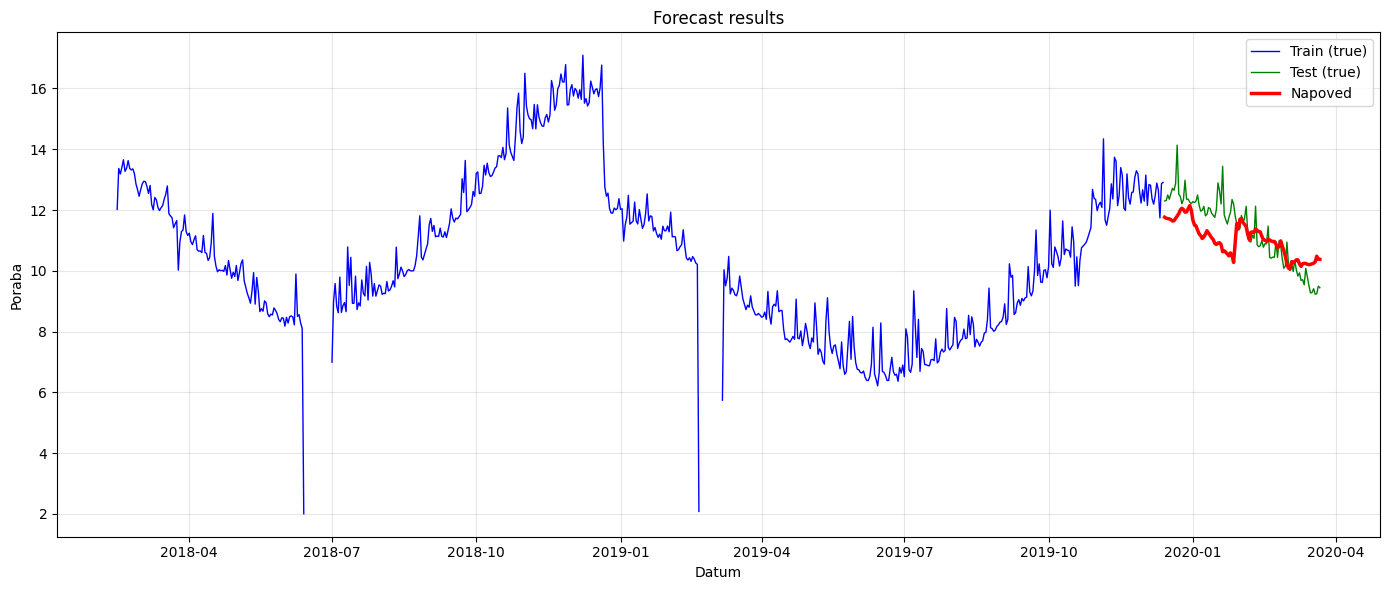

In [26]:
plot_forecast(series, latent_results, train_ratio=0.8)

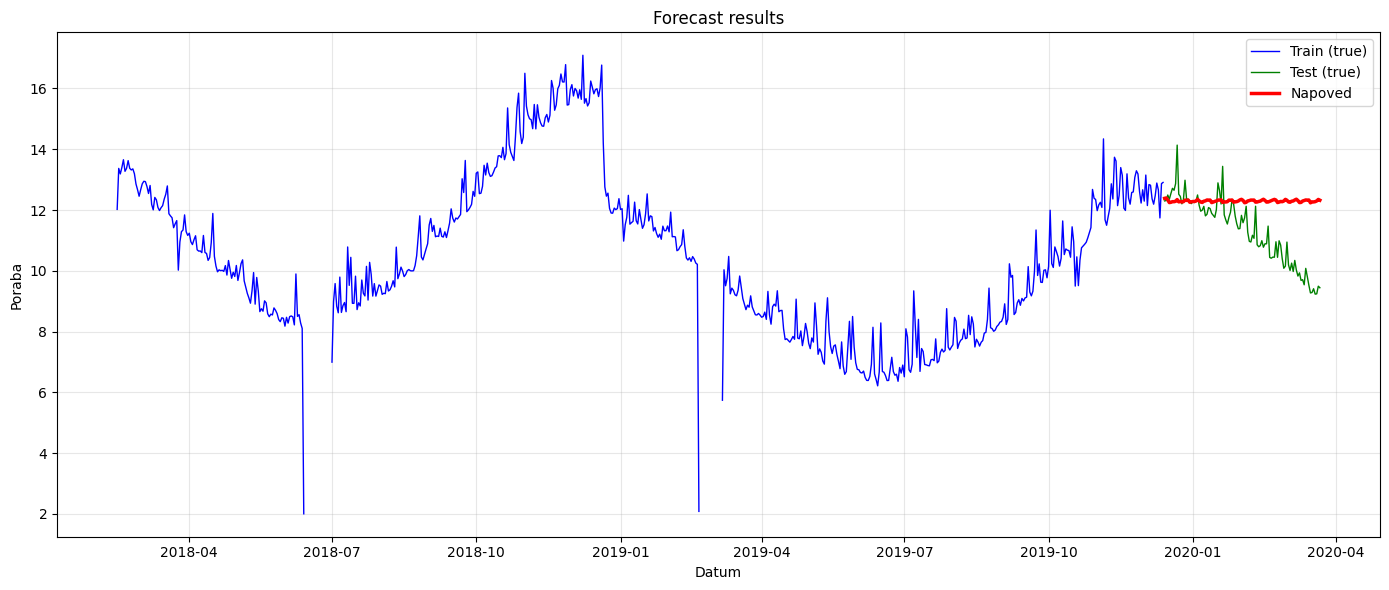

In [27]:
plot_forecast(series, baseline_results, train_ratio=0.8)

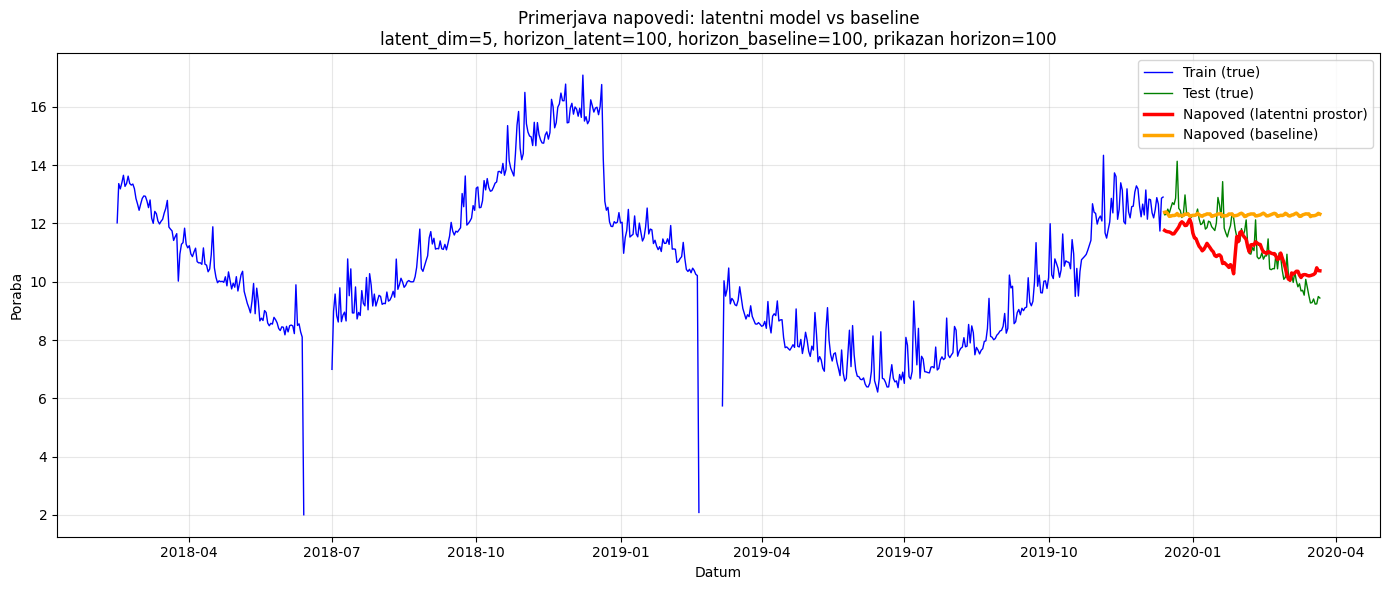

In [28]:
plot_forecast_comparison(series, latent_results, baseline_results, train_ratio=0.8)

### Še ena primerjava, nad več testnimi podatki

Feature columns: ['y', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_3', 'roll_mean_7']
Total samples after feature engineering: 716
Train samples: 537, Test samples: 179
Epoch 1/100
16/16 [==============================] - 0s 5ms/step - loss: 3081.3848 - val_loss: 5163.1167
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 1720.7909 - val_loss: 1819.2897
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 333.3294 - val_loss: 59.0821
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 42.8847 - val_loss: 30.5795
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 26.7409 - val_loss: 18.0418
Epoch 6/100
16/16 [==============================] - 0s 990us/step - loss: 15.4163 - val_loss: 6.0692
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 12.3821 - val_loss: 3.0412
Epoch 8/100
16/16 [==============================] -

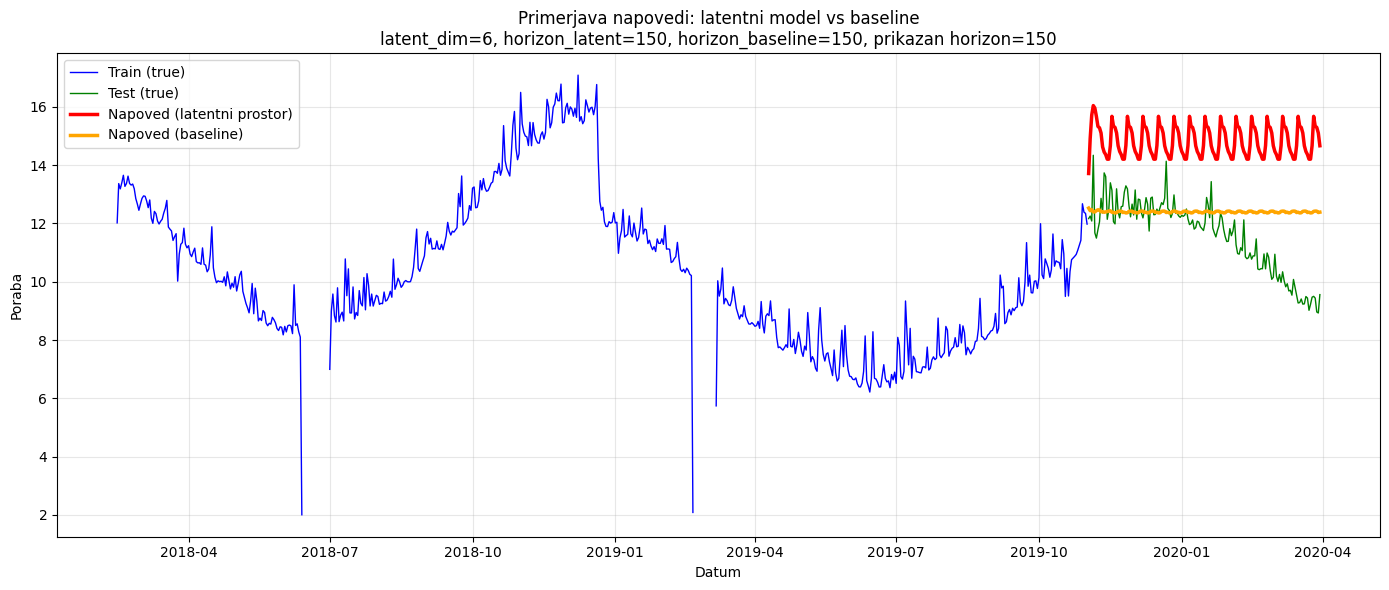

In [30]:
latent_results2 = run_experiment(
    series,
    latent_dim=6,
    forecast_horizon=150,
    train_ratio=0.75
)

baseline_results2 = run_baseline_experiment(
    series,
    forecast_horizon=150,
    train_ratio=0.75
)

plot_forecast_comparison(series, latent_results2, baseline_results2, train_ratio=0.75)

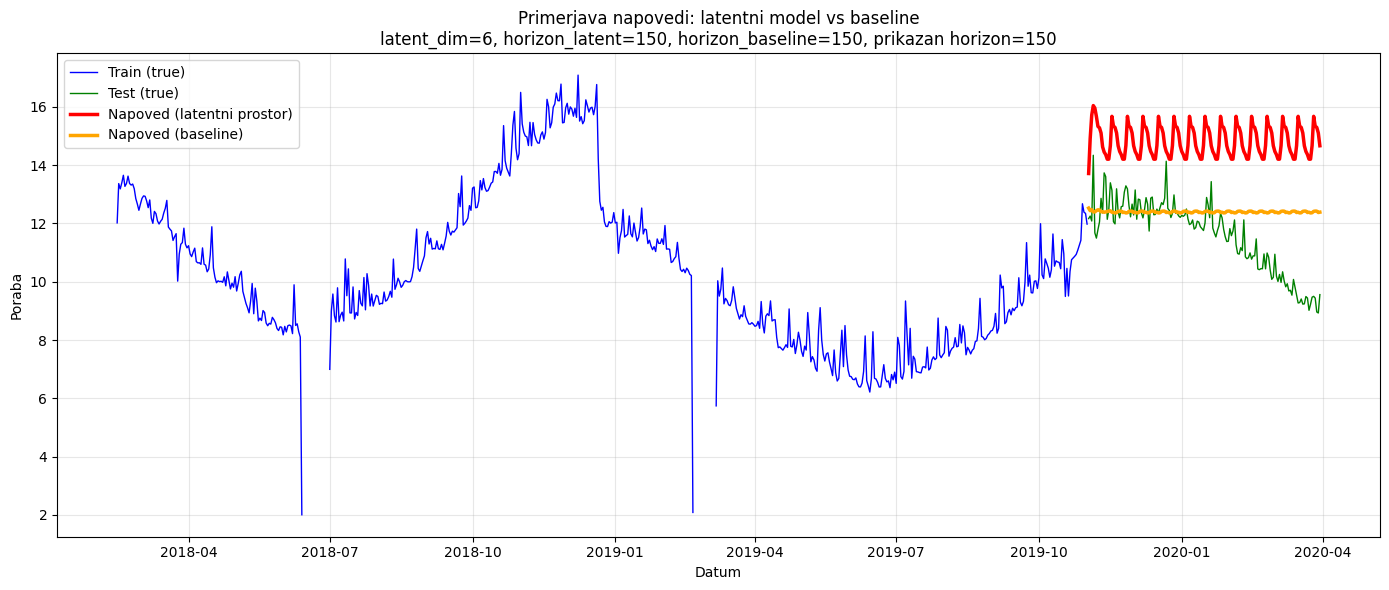

In [31]:
plot_forecast_comparison(series, latent_results2, baseline_results2, train_ratio=0.75)

Feature columns: ['y', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_3', 'roll_mean_7']
Total samples after feature engineering: 716
Train samples: 537, Test samples: 179
Epoch 1/100
16/16 [==============================] - 0s 5ms/step - loss: 3009.3713 - val_loss: 5286.7690
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 1933.3722 - val_loss: 2750.3416
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 727.6356 - val_loss: 537.7367
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 84.4706 - val_loss: 26.5992
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 41.3312 - val_loss: 16.0202
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 26.0146 - val_loss: 12.8832
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 20.0560 - val_loss: 7.6548
Epoch 8/100
16/16 [==============================] -

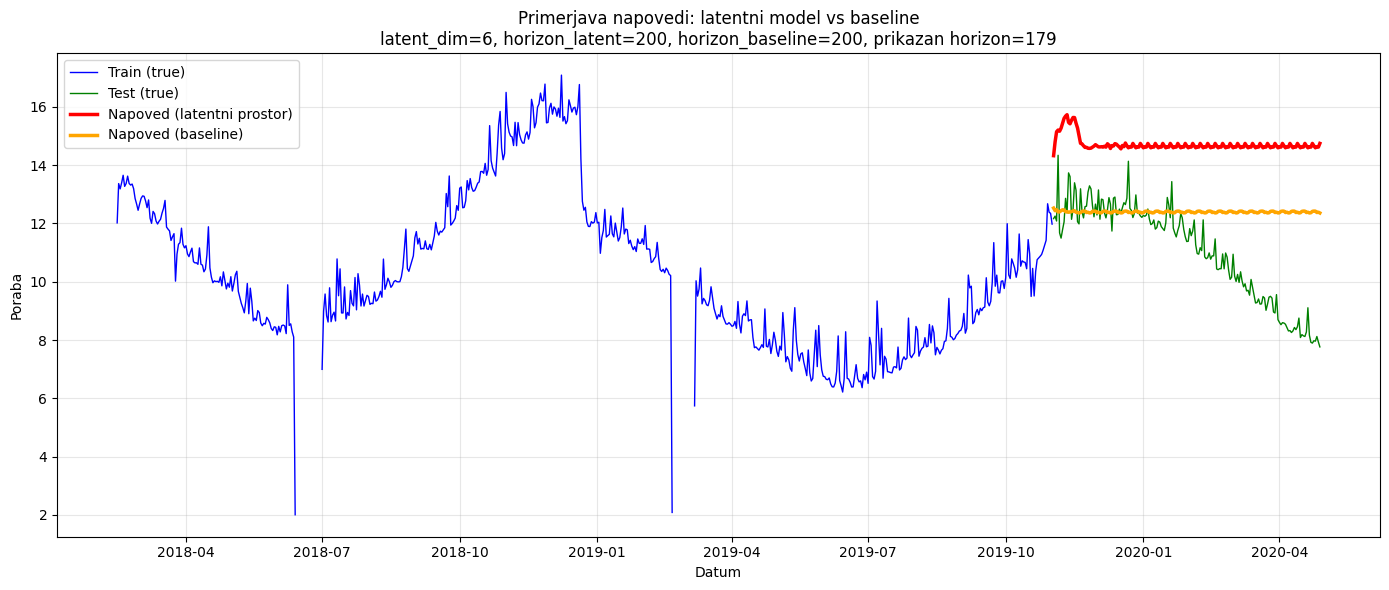

In [35]:
latent_results2 = run_experiment(
    series,
    latent_dim=6,
    forecast_horizon=200,
    train_ratio=0.75
)

baseline_results2 = run_baseline_experiment(
    series,
    forecast_horizon=200,
    train_ratio=0.75
)

plot_forecast_comparison(series, latent_results2, baseline_results2, train_ratio=0.75)